#**Appendix:**

In [ ]:

#Importing libraries:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
!pip install pydantic-settings
!pip install python-dotenv
from pydantic_settings import BaseSettings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import seaborn as sb
from sklearn import linear_model
from datetime import datetime
from timeit import default_timer as timer
from IPython.display import display
pd.set_option("display.max_columns", 10000)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', 1)
import random
! cp "/content/drive/MyDrive/My projects/Quantic School of Business and Technology and its Valar Institute/Strategic Investment Analysis /config.py" "/content"
! cp "/content/drive/MyDrive/My projects/Quantic School of Business and Technology and its Valar Institute/Strategic Investment Analysis /data.py" "/content"
! cp "/content/drive/MyDrive/My projects/Quantic School of Business and Technology and its Valar Institute/Strategic Investment Analysis /.env" "/content"
import config
from config import settings
import data
from data import SQLRepository
from data import AlphaVantageAPI
import requests
import pandas as pd
import numpy as np
from scipy.stats import norm
import sqlite3

!pip install arch
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Preparing to gathering data:**

In [ ]:
#Connecting to SQL to save datasets
connection = sqlite3.connect(database=settings.db_name,check_same_thread=False)
repo = SQLRepository(connection=connection)
print("repo type:", type(repo))
print("repo.connection type:", type(repo.connection))


repo type: <class 'data.SQLRepository'>
repo.connection type: <class 'sqlite3.Connection'>


In [ ]:
#Create a URL to get recent 2500 observations the stock data for Microsoft
ticker = "MSFT"
av = AlphaVantageAPI()
microsoft_records = av.get_daily(ticker=ticker)
# Insert `microsoft_records` database using `repo`
from data import SQLRepository
connection = sqlite3.connect(database=settings.db_name,check_same_thread=False)
repo = SQLRepository(connection=connection)
response = repo.insert_table(table_name=ticker, records=microsoft_records, if_exists="replace")
df_microsoft = repo.read_table(table_name=ticker,limit=2500)
print("df_microsoft type:", type(df_microsoft))
print("df_microsoft shape:", df_microsoft.shape)
df_microsoft.head()

df_microsoft type: <class 'pandas.core.frame.DataFrame'>
df_microsoft shape: (100, 5)


,open,high,low,close,volume
date,,,,,
2025-11-21,478.500,478.9200,468.27,472.12,31769248.0
2025-11-20,492.710,493.5700,475.50,478.43,26802542.0
2025-11-19,490.100,495.1872,482.83,487.12,23245314.0
2025-11-18,495.365,502.9800,486.78,493.79,33815114.0
2025-11-17,508.450,512.1200,504.91,507.49,19092752.0


In [ ]:
#Create a URL to get recent 2500 observations the stock data for Amazon  from AlphaVantage  and save it as Data Frame called  df_amazon

ticker = "AMZN"

av = AlphaVantageAPI()

amazon_records = av.get_daily(ticker=ticker)

# Insert `amazon_records` database using `repo`
from data import SQLRepository
connection = sqlite3.connect(database=settings.db_name,check_same_thread=False)
repo = SQLRepository(connection=connection)
response = repo.insert_table(table_name=ticker, records=amazon_records, if_exists="replace")

df_amazon = repo.read_table(table_name=ticker,limit=2500)

print("df_amazon type:", type(df_amazon))
print("df_amazon shape:", df_amazon.shape)
df_amazon.head()

df_amazon type: <class 'pandas.core.frame.DataFrame'>
df_amazon shape: (100, 5)


,open,high,low,close,volume
date,,,,,
2025-11-21,216.345,222.210,215.18,220.69,68490464.0
2025-11-20,227.050,227.410,216.74,217.14,50308962.0
2025-11-19,223.735,223.735,218.52,222.69,58335643.0
2025-11-18,228.100,230.200,222.42,222.55,60608442.0
2025-11-17,233.250,234.600,229.19,232.87,59919018.0


In [ ]:
#Create function to calculate 2500 most observations returns.
def wrangle_data(ticker,n_observations):

    """Extract table data from database. Calculate returns.

    Parameters
    ----------
    ticker : str
        The ticker symbol of the stock (also table name in database).

    n_observations : int
        Number of observations to return.

    Returns
    -------
    pd.Series
        Name will be `"return"`. There will be no `NaN` values.
    """
    # Get table from database
    df=repo.read_table(table_name=ticker,limit=n_observations+1)

    # Sort DataFrame ascending by date
    df.sort_index(ascending=True,inplace=True)


    # Create "return" column
    df["return"]=df["close"].pct_change()*100

    # Return returns
    return df["return"].dropna()

In [ ]:
#Create Amazon dataset that contains most returns of 2500 observations.
ticker = "AMZN"

y_amazon=wrangle_data(ticker,n_observations=2500)
print("y_amazon type:", type(y_amazon))
print("y_amazon shape:", y_amazon.shape)
y_amazon.head()

y_amazon type: <class 'pandas.core.series.Series'>
y_amazon shape: (99,)


,return
date,
2025-07-07,0.026856
2025-07-08,-1.839173
2025-07-09,1.449672
2025-07-10,-0.125820
2025-07-11,1.241789


In [ ]:
#Create Microsoft dataset that contains most recent returns of 2500 observations.

ticker = "MSFT"

y_microsoft=wrangle_data(ticker,n_observations=2500)
print("y_microsoft type:", type(y_microsoft))
print("y_microsoft shape:", y_microsoft.shape)
y_microsoft.head()

y_microsoft type: <class 'pandas.core.series.Series'>
y_microsoft shape: (99,)


,return
date,
2025-07-07,-0.224521
2025-07-08,-0.221008
2025-07-09,1.387379
2025-07-10,-0.403170
2025-07-11,0.366914


#**Volatility**



# **Exploring**
Let's create the volatility time series plot so that we have a visual aid to talk about what volatility is.

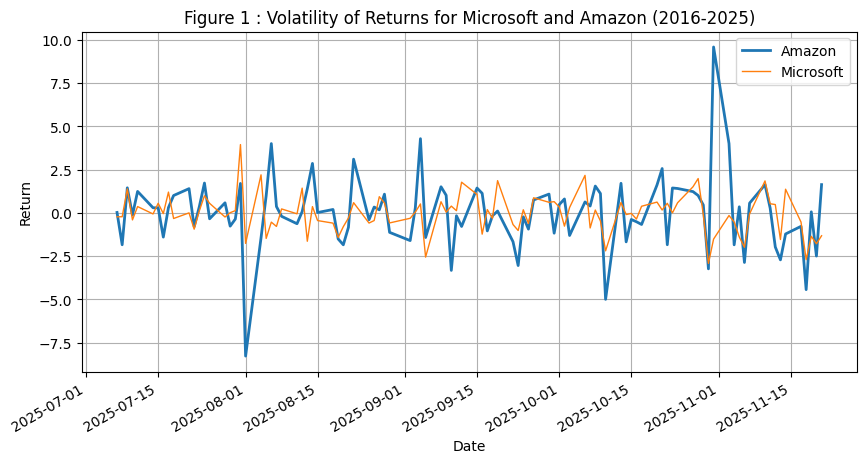

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot returns for `y_microsoft` and `y_amazon`
y_amazon.plot(ax=ax, label="Amazon",linewidth=2)
y_microsoft.plot(ax=ax, label="Microsoft",linewidth=1)

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")
# Add Title
plt.title("Figure 1 : Volatility of Returns for Microsoft and Amazon (2016-2025)")
# Add grid
plt.grid(True)
# Add legend
plt.legend();

 Let's create a histogram  about Distribution of Microsoft  Daily Returns  .


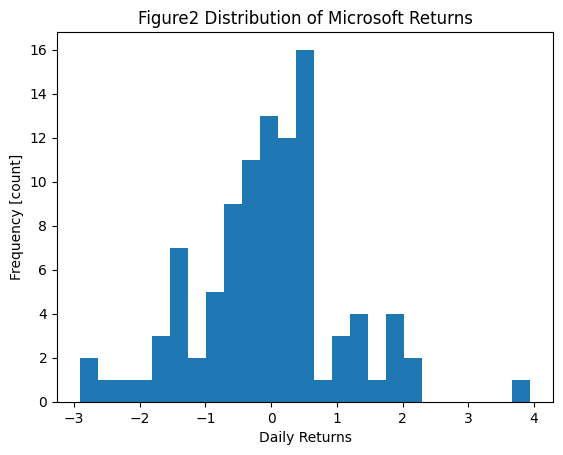

In [ ]:


plt.hist(y_microsoft,bins=25)
# Add axis labels
plt.xlabel("Daily Returns")
plt.ylabel("Frequency [count]")


# Add title
plt.title("Figure2 Distribution of Microsoft Returns");

 Create a histogram  about Distribution of Amazon  Daily Returns  .


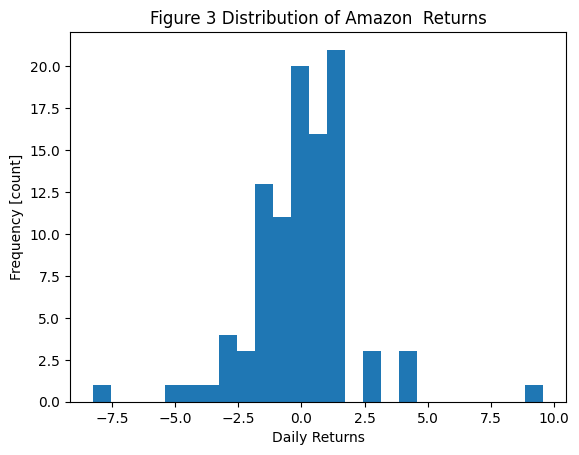

In [ ]:


plt.hist(y_amazon,bins=25)
# Add axis labels
plt.xlabel("Daily Returns")
plt.ylabel("Frequency [count]")


# Add title
plt.title("Figure 3 Distribution of Amazon  Returns");



Let's start by measuring the daily volatility of our two stocks. Since our data frequency is also daily, this will be exactly the same as calculating the standard deviation.


In [ ]:
microsoft_daily_volatility = y_microsoft.std()
amazon_daily_volatility = y_amazon.std()

print("Microsoft Daily Volatility:", microsoft_daily_volatility)
print("Amazon Daily Volatility:   ", amazon_daily_volatility)

Microsoft Daily Volatility: 1.1176618960991538
Amazon Daily Volatility:    2.0900660766106034


In [ ]:
microsoft_annual_volatility = microsoft_daily_volatility*np.sqrt(252)
amazon_annual_volatility = amazon_daily_volatility*np.sqrt(252)

print("Microsoft Annual Volatility:", microsoft_annual_volatility)
print("Amazon Annual Volatility:   ", amazon_annual_volatility)


Microsoft Annual Volatility: 17.742332561587634
Amazon Annual Volatility:    33.17877037442477


In [ ]:
amazon_rolling_50d_volatility = y_amazon.rolling(window=50).std().dropna()

print("rolling_50d_volatility type:", type(amazon_rolling_50d_volatility))
print("rolling_50d_volatility shape:", amazon_rolling_50d_volatility.shape)
amazon_rolling_50d_volatility.head()

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (50,)


,return
date,
2025-09-15,1.898897
2025-09-16,1.904588
2025-09-17,1.891176
2025-09-18,1.881896
2025-09-19,1.881628


In [ ]:
microsoft_rolling_50d_volatility = y_microsoft.rolling(window=50).std().dropna()

print("rolling_50d_volatility type:", type(microsoft_rolling_50d_volatility))
print("rolling_50d_volatility shape:", microsoft_rolling_50d_volatility.shape)
microsoft_rolling_50d_volatility.head()

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (50,)


,return
date,
2025-09-15,1.061014
2025-09-16,1.076054
2025-09-17,1.075513
2025-09-18,1.059378
2025-09-19,1.088806


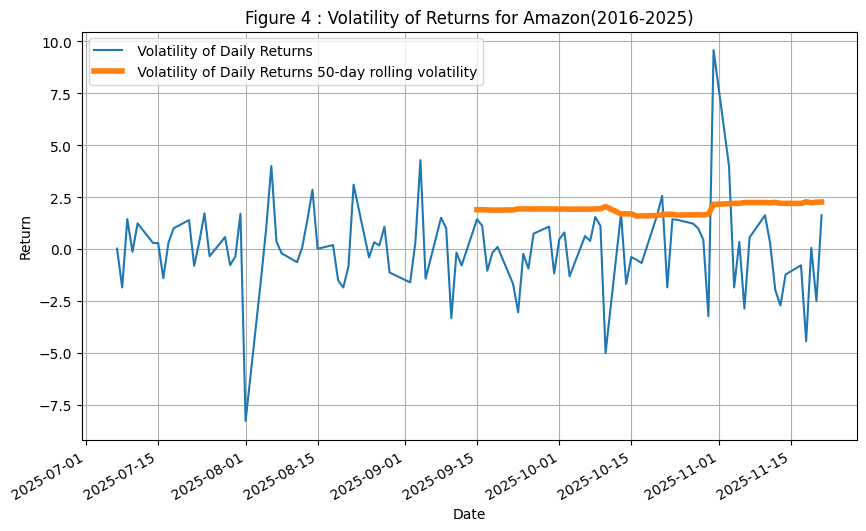

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot daily returns for `y_amazon`
y_amazon.plot(ax=ax, label=" Volatility of Daily Returns")
amazon_rolling_50d_volatility.plot(ax=ax, label=" Volatility of Daily Returns 50-day rolling volatility",linewidth=4)

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")
# Add Title
plt.title("Figure 4 : Volatility of Returns for Amazon(2016-2025)")
# Add grid
plt.grid(True)
# Add legend
plt.legend();

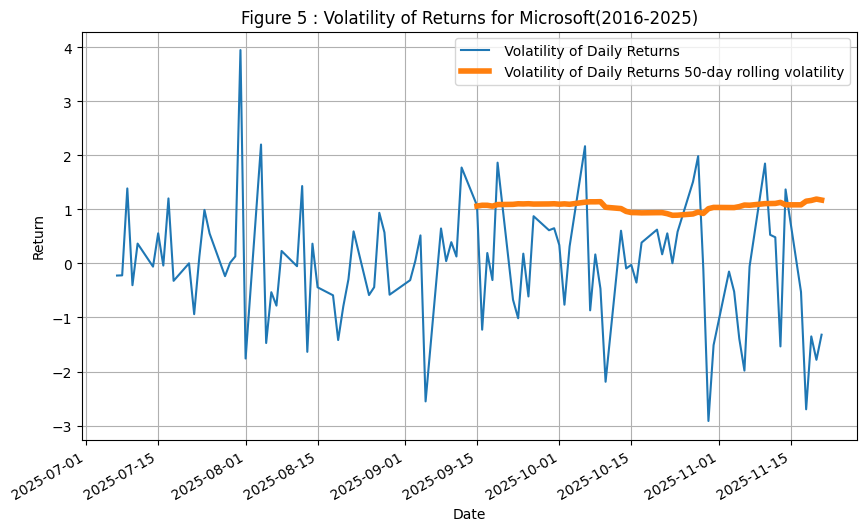

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot daily returns for `y_amazon`
y_microsoft.plot(ax=ax, label=" Volatility of Daily Returns")
microsoft_rolling_50d_volatility.plot(ax=ax, label=" Volatility of Daily Returns 50-day rolling volatility",linewidth=4)

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")
# Add Title
plt.title("Figure 5 : Volatility of Returns for Microsoft(2016-2025)")
# Add grid
plt.grid(True)
# Add legend
plt.legend();

Let's create a time series plot of the squared returns in Amazon and Microsoft returns

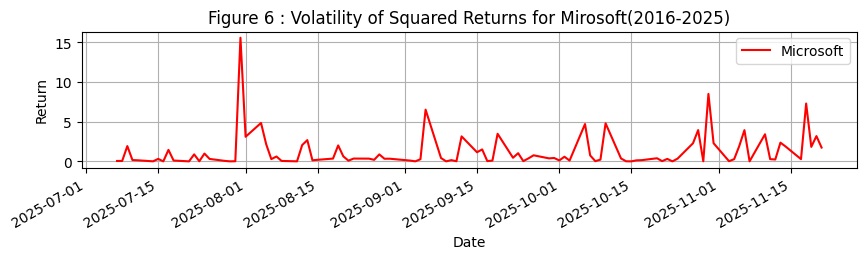

In [ ]:

fig, ax = plt.subplots(figsize=(10, 2))

(y_microsoft**2).plot(ax=ax, label="Microsoft",linewidth=1.5,color='red')

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")
# Add Title
plt.title("Figure 6 : Volatility of Squared Returns for Mirosoft(2016-2025)")
# Add grid
plt.grid(True)
# Add legend
plt.legend();




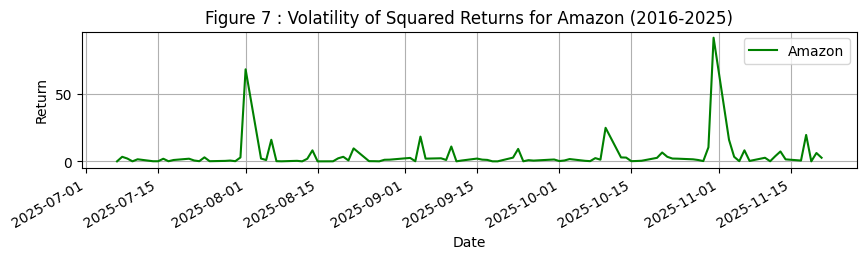

In [ ]:

fig, ax = plt.subplots(figsize=(10, 2))


(y_amazon**2).plot(ax=ax, label="Amazon",linewidth=1.5,color="green")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")
# Add Title
plt.title("Figure 7 : Volatility of Squared Returns for Amazon (2016-2025)")
# Add grid
plt.grid(True)
# Add legend
plt.legend();




In [ ]:
df_amazon.to_csv("/content/drive/MyDrive/Capstone project-EMBA-Valar/df_amazon.csv",index=True)
df_microsoft.to_csv("/content/drive/MyDrive/Capstone project-EMBA-Valar/df_microsoft.csv",index=True)
y_amazon.to_csv("/content/drive/MyDrive/Capstone project-EMBA-Valar/y_amazon.csv",index=True)
y_microsoft.to_csv("/content/drive/MyDrive/Capstone project-EMBA-Valar/y_microsoft.csv",index=True)



#**MICROSOFT STOCK VOLATILITY ANALYSIS REPORT**

---



MICROSOFT STOCK VOLATILITY ANALYSIS REPORT

----------------------- Model Parameters and Diagnostics -----------------------
+---------------------------+----------+--------------------------------------------+
| Parameter                 | Value    | Interpretation                             |
+===========================+==========+============================================+
| Omega (ω)                 | 0.927038 | Baseline volatility level                  |
+---------------------------+----------+--------------------------------------------+
| Alpha (α)                 | 0.217982 | Impact of recent shocks                    |
+---------------------------+----------+--------------------------------------------+
| Beta (β)                  | 0.028077 | Long-term volatility memory                |
+---------------------------+----------+--------------------------------------------+
| Persistence (α+β)         | 0.2461   | Duration of volatility shocks (High >0.9)  |
+--------------

/tmp/ipython-input-1186087632.py:86: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  returns.last('90D').plot(ax=ax2, title='Recent Returns (90 Days)', color='darkgreen')


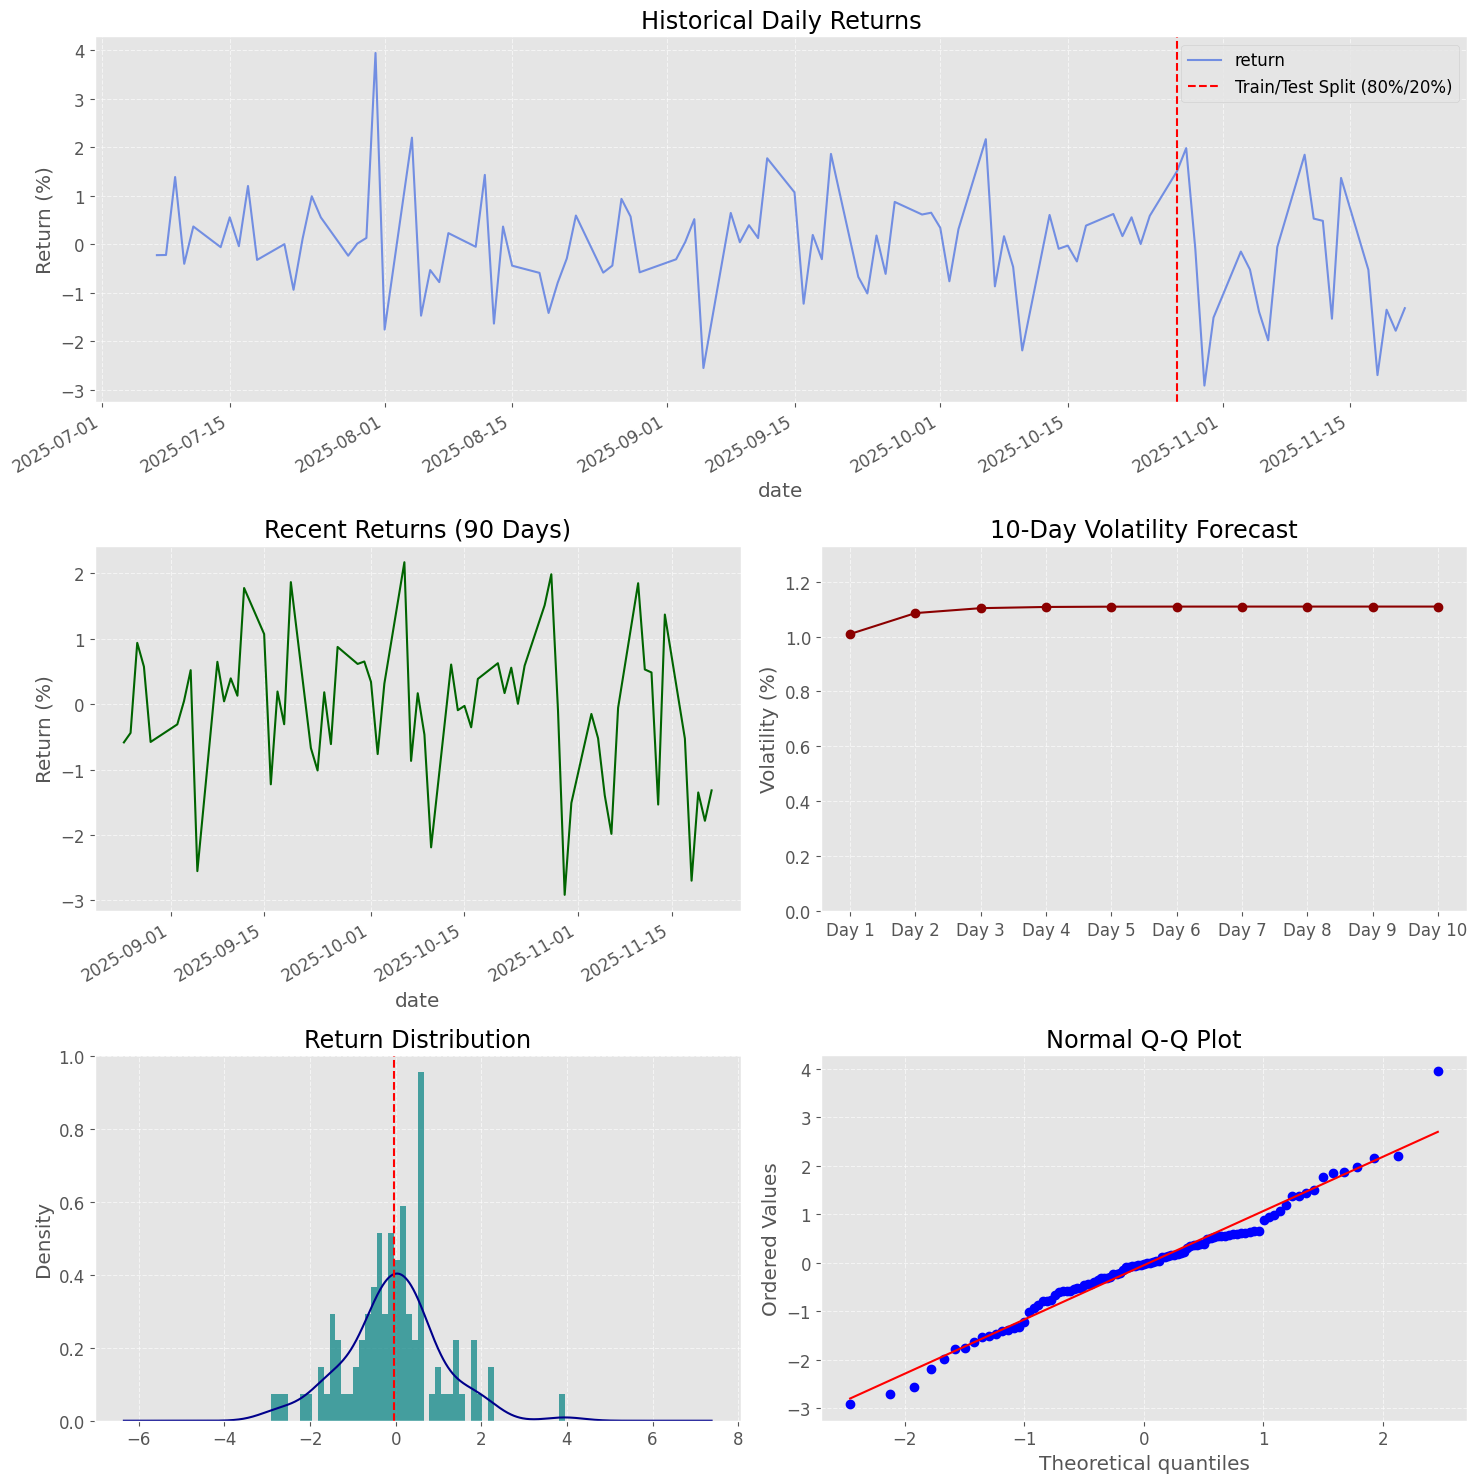

In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from tabulate import tabulate

import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from tabulate import tabulate

# Updated style configuration with fallback
available_styles = plt.style.available
if 'seaborn-whitegrid' in available_styles:
    plt.style.use('seaborn-whitegrid')
elif 'seaborn' in available_styles:
    plt.style.use('seaborn')
elif 'ggplot' in available_styles:
    plt.style.use('ggplot')
else:
    print("Using default matplotlib style")

plt.rcParams.update({
    'font.size': 12,
    'figure.figsize': (14, 10),
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.6
})

def load_and_prepare_data(file_path):
    """Load and prepare time series data"""
    data = pd.read_csv(file_path, parse_dates=['date'])
    data = data[['date', 'return']].copy()
    data['return'] = pd.to_numeric(data['return'], errors='coerce')
    data = data.dropna(subset=['return']).reset_index(drop=True)
    data.set_index('date', inplace=True)
    return data

def fit_garch_model(returns):
    """Fit GARCH(1,1) model with Student's t-distribution"""
    model = arch_model(returns, vol='Garch', p=1, q=1, dist='StudentsT', rescale=False)
    return model.fit(disp='off')

def run_diagnostics(residuals, lags=10):
    """Run model diagnostic tests"""
    lb_test = acorr_ljungbox(residuals, lags=lags, return_df=True)
    arch_test = het_arch(residuals)
    return {
        'Ljung-Box': lb_test['lb_pvalue'].values,
        'ARCH-LM': arch_test[1]
    }

def calculate_var(mean_return, volatility, nu, confidence=0.05):
    """Calculate Value at Risk using t-distribution"""
    return mean_return + volatility * stats.t.ppf(confidence, df=nu)

def generate_volatility_forecast(model, horizon=10):
    """Generate volatility forecasts"""
    forecast = model.forecast(horizon=horizon)
    variance = forecast.variance.iloc[-1].values
    return np.sqrt(variance)  # Convert to volatility

def plot_results(returns, train_size, forecasted_vol):
    """Visualize results with comprehensive plots"""
    fig = plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(3, 2, figure=fig)

    # Historical returns
    ax1 = fig.add_subplot(gs[0, :])
    returns.plot(ax=ax1, title='Historical Daily Returns', color='royalblue', alpha=0.7)
    ax1.axvline(returns.index[train_size], color='r', linestyle='--',
               label='Train/Test Split (80%/20%)')
    ax1.set_ylabel('Return (%)')
    ax1.legend()

    # Recent returns (last 3 months)
    ax2 = fig.add_subplot(gs[1, 0])
    returns.last('90D').plot(ax=ax2, title='Recent Returns (90 Days)', color='darkgreen')
    ax2.set_ylabel('Return (%)')

    # Volatility forecast
    ax3 = fig.add_subplot(gs[1, 1])
    horizons = [f'Day {i+1}' for i in range(len(forecasted_vol))]
    ax3.plot(horizons, forecasted_vol, 'o-', color='darkred')
    ax3.set_title('10-Day Volatility Forecast')
    ax3.set_ylabel('Volatility (%)')
    ax3.set_ylim(0, max(forecasted_vol)*1.2)

    # Return distribution
    ax4 = fig.add_subplot(gs[2, 0])
    returns.plot(kind='hist', bins=50, ax=ax4, density=True,
                color='teal', alpha=0.7, title='Return Distribution')
    returns.plot(kind='kde', ax=ax4, color='darkblue')
    ax4.axvline(returns.mean(), color='red', linestyle='--', label='Mean')

    # QQ-Plot
    ax5 = fig.add_subplot(gs[2, 1])
    stats.probplot(returns, dist="norm", plot=ax5)
    ax5.set_title('Normal Q-Q Plot')

    plt.tight_layout()
    plt.savefig('volatility_analysis.png', dpi=300)
    plt.show()

def generate_investment_implications(params, forecast, var):
    """Generate strategic investment implications"""
    implications = []
    persistence = params['alpha'] + params['beta']

    # Persistence implications
    if persistence > 0.9:
        implications.append({
            'Factor': 'High Volatility Persistence (α+β>0.9)',
            'Implication': 'Long-lasting volatility shocks',
            'Action': 'Reduce exposure, use protective puts'
        })
    else:
        implications.append({
            'Factor': 'Moderate Volatility Persistence',
            'Implication': 'Faster volatility reversion',
            'Action': 'Suitable for tactical trading'
        })

    # ARCH term implications
    if params['alpha'] > 0.3:
        implications.append({
            'Factor': 'High ARCH Term (α>0.3)',
            'Implication': 'Recent shocks drive volatility',
            'Action': 'Implement stop-loss orders'
        })

    # GARCH term implications
    if params['beta'] > 0.7:
        implications.append({
            'Factor': 'High GARCH Term (β>0.7)',
            'Implication': 'Stable volatility regimes',
            'Action': 'Long-term risk budgeting'
        })

    # Tail risk implications
    if params['nu'] < 5:
        implications.append({
            'Factor': 'Fat Tails (ν<5)',
            'Implication': 'Higher extreme return risk',
            'Action': 'Increase hedging, monitor tail risks'
        })

    # Volatility forecast implications
    hist_vol = returns.abs().mean()
    if forecast[0] > hist_vol:
        implications.append({
            'Factor': f'High Forecasted Volatility ({forecast[0]:.2f}% > {hist_vol:.2f}%)',
            'Implication': 'Increased near-term risk',
            'Action': 'Reduce position sizes, consider hedging'
        })

    # VaR implications
    implications.append({
        'Factor': f'1-Day VaR ({var:.2f}%)',
        'Implication': 'Potential loss threshold',
        'Action': 'Set stop-loss levels, allocate capital accordingly'
    })

    return pd.DataFrame(implications)

# Main analysis
if __name__ == "__main__":
    # Load and prepare data
    data = load_and_prepare_data("/content/drive/MyDrive/Capstone project-EMBA-Valar/y_microsoft.csv")
    returns = data['return']

    # Split data (80% train, 20% test)
    train_size = int(0.8 * len(returns))
    train_data = returns[:train_size]
    test_data = returns[train_size:]

    # Fit GARCH model
    results = fit_garch_model(train_data)
    params = {
        'omega': results.params['omega'],
        'alpha': results.params['alpha[1]'],
        'beta': results.params['beta[1]'],
        'nu': results.params['nu'],
        'persistence': results.params['alpha[1]'] + results.params['beta[1]']
    }

    # Run diagnostics
    residuals = results.std_resid.dropna()
    diagnostics = run_diagnostics(residuals)

    # Generate forecasts
    forecasted_vol = generate_volatility_forecast(results)

    # Calculate VaR
    mean_return = train_data.mean()
    var_95 = calculate_var(mean_return, forecasted_vol[0]/100, params['nu'])

    # Create summary table
    summary_table = [
        ["Parameter", "Value", "Interpretation"],
        ["Omega (ω)", f"{params['omega']:.6f}", "Baseline volatility level"],
        ["Alpha (α)", f"{params['alpha']:.6f}", "Impact of recent shocks"],
        ["Beta (β)", f"{params['beta']:.6f}", "Long-term volatility memory"],
        ["Persistence (α+β)", f"{params['persistence']:.4f}",
         "Duration of volatility shocks (High >0.9)"],
        ["Degrees of Freedom (ν)", f"{params['nu']:.2f}",
         "Tail thickness (Lower = fatter tails)"],
        ["AIC", f"{results.aic:.2f}", "Model fit (Lower = better)"],
        ["BIC", f"{results.bic:.2f}", "Model fit (Lower = better)"],
        ["ARCH-LM p-value", f"{diagnostics['ARCH-LM']:.4f}",
         "Remaining ARCH effects (<0.05 significant)"],
        ["1-Day VaR (95%)", f"{var_95:.2f}%", "Potential daily loss threshold"],
        ["Day 1 Volatility Forecast", f"{forecasted_vol[0]:.2f}%",
         "Expected near-term volatility"]
    ]

    # Print results
    print("="*80)
    print("MICROSOFT STOCK VOLATILITY ANALYSIS REPORT")
    print("="*80)
    print(f"\n{' Model Parameters and Diagnostics ':-^80}")
    print(tabulate(summary_table, headers="firstrow", tablefmt="grid"))

    print(f"\n{' Strategic Investment Implications ':-^80}")
    implications_df = generate_investment_implications(params, forecasted_vol, var_95)
    print(tabulate(implications_df, headers='keys', tablefmt='grid', showindex=False))

    print(f"\n{' Forecasted Volatility ':-^80}")
    forecast_df = pd.DataFrame({
        'Horizon': [f'Day {i+1}' for i in range(10)],
        'Volatility (%)': [f"{v:.2f}%" for v in forecasted_vol]
    })
    print(tabulate(forecast_df, headers='keys', tablefmt='grid', showindex=False))

    # Generate plots
    plot_results(returns, train_size, forecasted_vol)

#**AMAZON STOCK VOLATILITY ANALYSIS REPORT**

---



AMAZON STOCK VOLATILITY ANALYSIS REPORT

----------------------- Model Parameters and Diagnostics -----------------------
+---------------------------+----------+--------------------------------------------+
| Parameter                 | Value    | Interpretation                             |
+===========================+==========+============================================+
| Omega (ω)                 | 0.028600 | Baseline volatility level                  |
+---------------------------+----------+--------------------------------------------+
| Alpha (α)                 | 0.000000 | Impact of recent shocks                    |
+---------------------------+----------+--------------------------------------------+
| Beta (β)                  | 1.000000 | Long-term volatility memory                |
+---------------------------+----------+--------------------------------------------+
| Persistence (α+β)         | 1.0000   | Duration of volatility shocks (High >0.9)  |
+-----------------

/tmp/ipython-input-1952942018.py:86: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  returns.last('90D').plot(ax=ax2, title='Recent Returns (90 Days)', color='darkgreen')


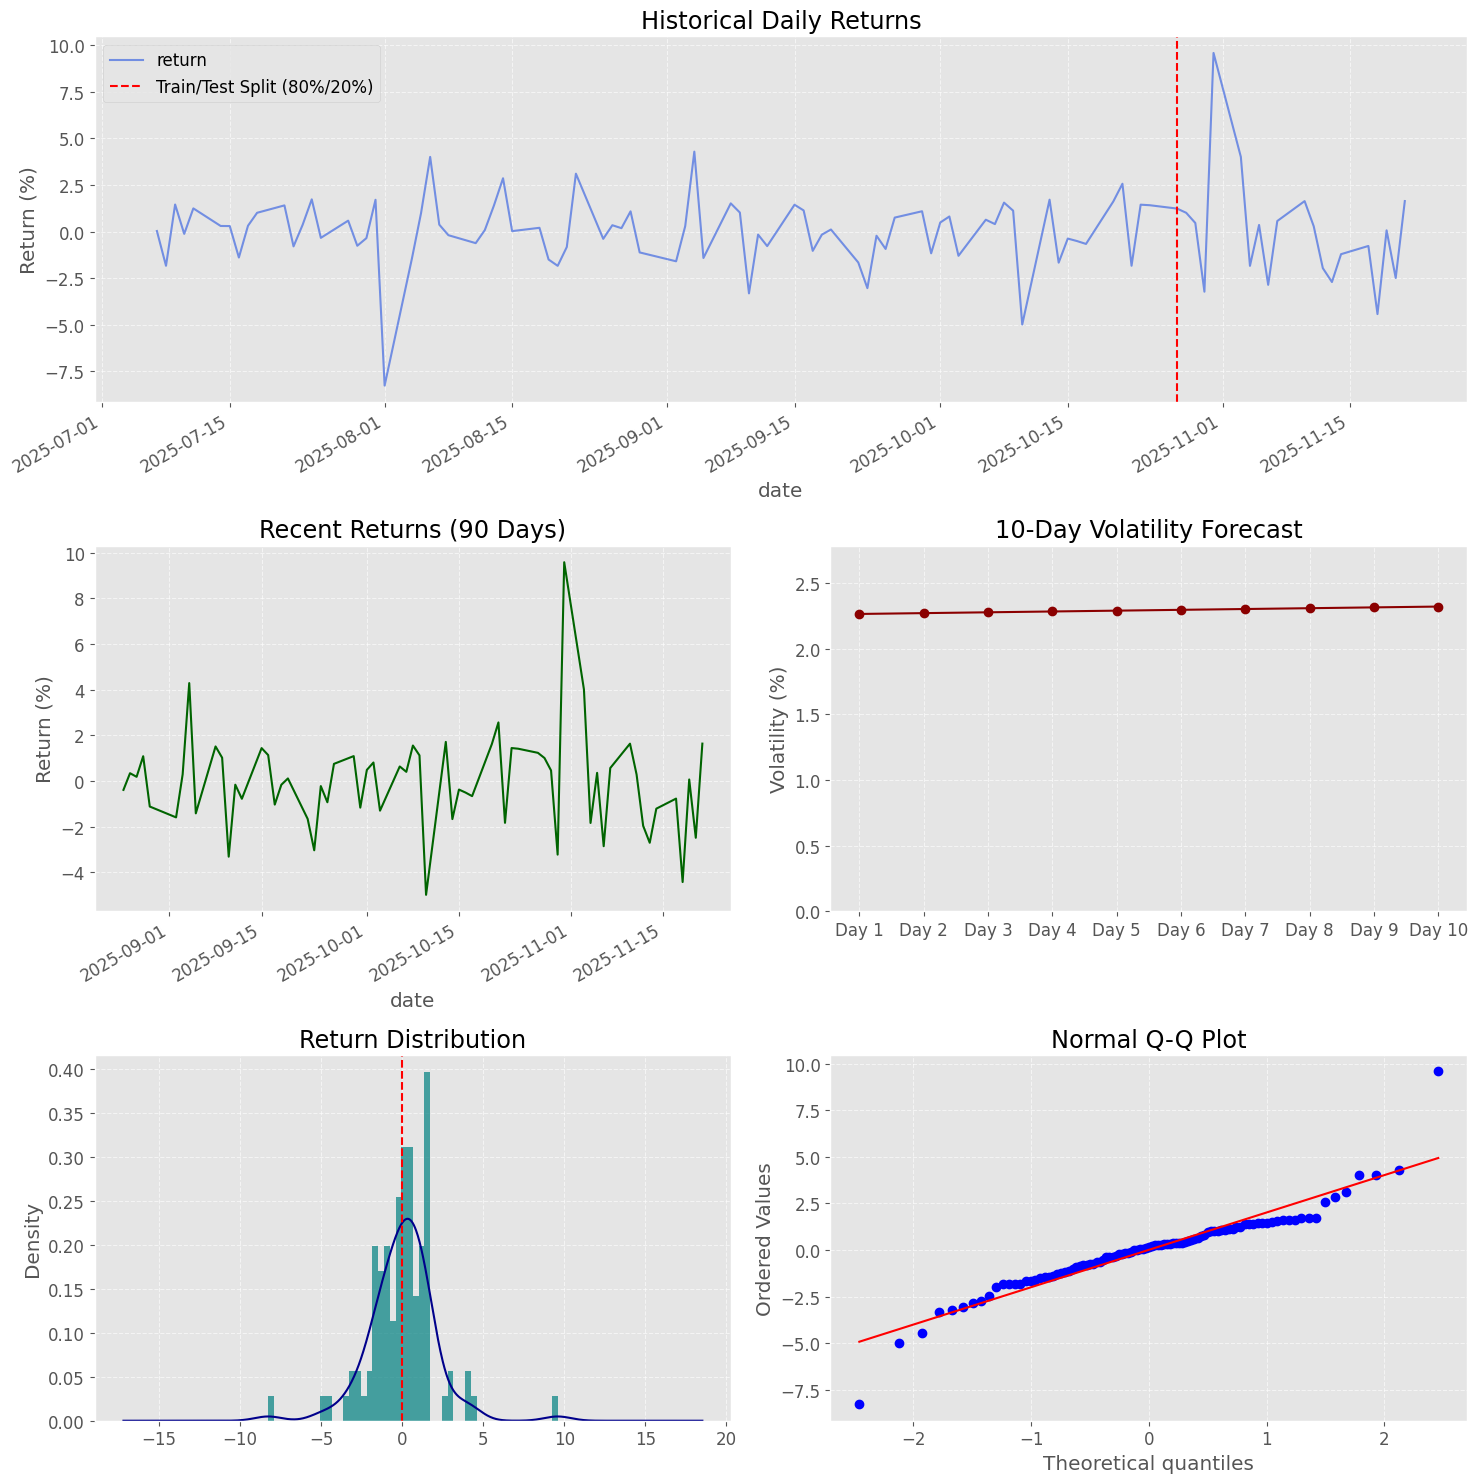

In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from tabulate import tabulate

import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from tabulate import tabulate

# Updated style configuration with fallback
available_styles = plt.style.available
if 'seaborn-whitegrid' in available_styles:
    plt.style.use('seaborn-whitegrid')
elif 'seaborn' in available_styles:
    plt.style.use('seaborn')
elif 'ggplot' in available_styles:
    plt.style.use('ggplot')
else:
    print("Using default matplotlib style")

plt.rcParams.update({
    'font.size': 12,
    'figure.figsize': (14, 10),
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.6
})

def load_and_prepare_data(file_path):
    """Load and prepare time series data"""
    data = pd.read_csv(file_path, parse_dates=['date'])
    data = data[['date', 'return']].copy()
    data['return'] = pd.to_numeric(data['return'], errors='coerce')
    data = data.dropna(subset=['return']).reset_index(drop=True)
    data.set_index('date', inplace=True)
    return data

def fit_garch_model(returns):
    """Fit GARCH(1,1) model with Student's t-distribution"""
    model = arch_model(returns, vol='Garch', p=1, q=1, dist='StudentsT', rescale=False)
    return model.fit(disp='off')

def run_diagnostics(residuals, lags=10):
    """Run model diagnostic tests"""
    lb_test = acorr_ljungbox(residuals, lags=lags, return_df=True)
    arch_test = het_arch(residuals)
    return {
        'Ljung-Box': lb_test['lb_pvalue'].values,
        'ARCH-LM': arch_test[1]
    }

def calculate_var(mean_return, volatility, nu, confidence=0.05):
    """Calculate Value at Risk using t-distribution"""
    return mean_return + volatility * stats.t.ppf(confidence, df=nu)

def generate_volatility_forecast(model, horizon=10):
    """Generate volatility forecasts"""
    forecast = model.forecast(horizon=horizon)
    variance = forecast.variance.iloc[-1].values
    return np.sqrt(variance)  # Convert to volatility

def plot_results(returns, train_size, forecasted_vol):
    """Visualize results with comprehensive plots"""
    fig = plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(3, 2, figure=fig)

    # Historical returns
    ax1 = fig.add_subplot(gs[0, :])
    returns.plot(ax=ax1, title='Historical Daily Returns', color='royalblue', alpha=0.7)
    ax1.axvline(returns.index[train_size], color='r', linestyle='--',
               label='Train/Test Split (80%/20%)')
    ax1.set_ylabel('Return (%)')
    ax1.legend()

    # Recent returns (last 3 months)
    ax2 = fig.add_subplot(gs[1, 0])
    returns.last('90D').plot(ax=ax2, title='Recent Returns (90 Days)', color='darkgreen')
    ax2.set_ylabel('Return (%)')

    # Volatility forecast
    ax3 = fig.add_subplot(gs[1, 1])
    horizons = [f'Day {i+1}' for i in range(len(forecasted_vol))]
    ax3.plot(horizons, forecasted_vol, 'o-', color='darkred')
    ax3.set_title('10-Day Volatility Forecast')
    ax3.set_ylabel('Volatility (%)')
    ax3.set_ylim(0, max(forecasted_vol)*1.2)

    # Return distribution
    ax4 = fig.add_subplot(gs[2, 0])
    returns.plot(kind='hist', bins=50, ax=ax4, density=True,
                color='teal', alpha=0.7, title='Return Distribution')
    returns.plot(kind='kde', ax=ax4, color='darkblue')
    ax4.axvline(returns.mean(), color='red', linestyle='--', label='Mean')

    # QQ-Plot
    ax5 = fig.add_subplot(gs[2, 1])
    stats.probplot(returns, dist="norm", plot=ax5)
    ax5.set_title('Normal Q-Q Plot')

    plt.tight_layout()
    plt.savefig('volatility_analysis.png', dpi=300)
    plt.show()

def generate_investment_implications(params, forecast, var):
    """Generate strategic investment implications"""
    implications = []
    persistence = params['alpha'] + params['beta']

    # Persistence implications
    if persistence > 0.9:
        implications.append({
            'Factor': 'High Volatility Persistence (α+β>0.9)',
            'Implication': 'Long-lasting volatility shocks',
            'Action': 'Reduce exposure, use protective puts'
        })
    else:
        implications.append({
            'Factor': 'Moderate Volatility Persistence',
            'Implication': 'Faster volatility reversion',
            'Action': 'Suitable for tactical trading'
        })

    # ARCH term implications
    if params['alpha'] > 0.3:
        implications.append({
            'Factor': 'High ARCH Term (α>0.3)',
            'Implication': 'Recent shocks drive volatility',
            'Action': 'Implement stop-loss orders'
        })

    # GARCH term implications
    if params['beta'] > 0.7:
        implications.append({
            'Factor': 'High GARCH Term (β>0.7)',
            'Implication': 'Stable volatility regimes',
            'Action': 'Long-term risk budgeting'
        })

    # Tail risk implications
    if params['nu'] < 5:
        implications.append({
            'Factor': 'Fat Tails (ν<5)',
            'Implication': 'Higher extreme return risk',
            'Action': 'Increase hedging, monitor tail risks'
        })

    # Volatility forecast implications
    hist_vol = returns.abs().mean()
    if forecast[0] > hist_vol:
        implications.append({
            'Factor': f'High Forecasted Volatility ({forecast[0]:.2f}% > {hist_vol:.2f}%)',
            'Implication': 'Increased near-term risk',
            'Action': 'Reduce position sizes, consider hedging'
        })

    # VaR implications
    implications.append({
        'Factor': f'1-Day VaR ({var:.2f}%)',
        'Implication': 'Potential loss threshold',
        'Action': 'Set stop-loss levels, allocate capital accordingly'
    })

    return pd.DataFrame(implications)

# Main analysis
if __name__ == "__main__":
    # Load and prepare data
    data = load_and_prepare_data("/content/drive/MyDrive/Capstone project-EMBA-Valar/y_amazon.csv")
    returns = data['return']

    # Split data (80% train, 20% test)
    train_size = int(0.8 * len(returns))
    train_data = returns[:train_size]
    test_data = returns[train_size:]

    # Fit GARCH model
    results = fit_garch_model(train_data)
    params = {
        'omega': results.params['omega'],
        'alpha': results.params['alpha[1]'],
        'beta': results.params['beta[1]'],
        'nu': results.params['nu'],
        'persistence': results.params['alpha[1]'] + results.params['beta[1]']
    }

    # Run diagnostics
    residuals = results.std_resid.dropna()
    diagnostics = run_diagnostics(residuals)

    # Generate forecasts
    forecasted_vol = generate_volatility_forecast(results)

    # Calculate VaR
    mean_return = train_data.mean()
    var_95 = calculate_var(mean_return, forecasted_vol[0]/100, params['nu'])

    # Create summary table
    summary_table = [
        ["Parameter", "Value", "Interpretation"],
        ["Omega (ω)", f"{params['omega']:.6f}", "Baseline volatility level"],
        ["Alpha (α)", f"{params['alpha']:.6f}", "Impact of recent shocks"],
        ["Beta (β)", f"{params['beta']:.6f}", "Long-term volatility memory"],
        ["Persistence (α+β)", f"{params['persistence']:.4f}",
         "Duration of volatility shocks (High >0.9)"],
        ["Degrees of Freedom (ν)", f"{params['nu']:.2f}",
         "Tail thickness (Lower = fatter tails)"],
        ["AIC", f"{results.aic:.2f}", "Model fit (Lower = better)"],
        ["BIC", f"{results.bic:.2f}", "Model fit (Lower = better)"],
        ["ARCH-LM p-value", f"{diagnostics['ARCH-LM']:.4f}",
         "Remaining ARCH effects (<0.05 significant)"],
        ["1-Day VaR (95%)", f"{var_95:.2f}%", "Potential daily loss threshold"],
        ["Day 1 Volatility Forecast", f"{forecasted_vol[0]:.2f}%",
         "Expected near-term volatility"]
    ]

    # Print results
    print("="*80)
    print("AMAZON STOCK VOLATILITY ANALYSIS REPORT")
    print("="*80)
    print(f"\n{' Model Parameters and Diagnostics ':-^80}")
    print(tabulate(summary_table, headers="firstrow", tablefmt="grid"))

    print(f"\n{' Strategic Investment Implications ':-^80}")
    implications_df = generate_investment_implications(params, forecasted_vol, var_95)
    print(tabulate(implications_df, headers='keys', tablefmt='grid', showindex=False))

    print(f"\n{' Forecasted Volatility ':-^80}")
    forecast_df = pd.DataFrame({
        'Horizon': [f'Day {i+1}' for i in range(10)],
        'Volatility (%)': [f"{v:.2f}%" for v in forecasted_vol]
    })
    print(tabulate(forecast_df, headers='keys', tablefmt='grid', showindex=False))

    # Generate plots
    plot_results(returns, train_size, forecasted_vol)

In [ ]:
#@title Convert ipynb to HTML in Colab
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")

Saving Capstone_project_EMBA_Valar.ipynb to Capstone_project_EMBA_Valar.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>